# Insertion algorithm 

In [3]:
%matplotlib inline

import numpy as np
import os 
import math 
import matplotlib.pyplot as plt
import matplotlib
import sys 
import torch 
import seaborn as sns

print(torch.__version__)

import signatory
import itertools
import cvxpy as cp

1.5.0


In [4]:
test_tensor = torch.rand((3,3,3))
print(test_tensor)

print(test_tensor[0,1,2])

tensor([[[0.4786, 0.6928, 0.2547],
         [0.1010, 0.1392, 0.6793],
         [0.6761, 0.6344, 0.5665]],

        [[0.4570, 0.2712, 0.3174],
         [0.1172, 0.6881, 0.7066],
         [0.2310, 0.0726, 0.9306]],

        [[0.5993, 0.2889, 0.7625],
         [0.4604, 0.2071, 0.3191],
         [0.4022, 0.0555, 0.5511]]])
tensor(0.6793)


## Insertion operator 

In [5]:
test_path = torch.rand((1,10,5))

print(test_path)

tensor([[[0.4581, 0.0652, 0.7990, 0.3512, 0.9361],
         [0.0591, 0.9760, 0.3213, 0.5383, 0.7274],
         [0.3892, 0.4510, 0.3785, 0.0465, 0.6059],
         [0.3356, 0.2946, 0.7191, 0.1583, 0.2623],
         [0.3606, 0.9535, 0.9057, 0.5000, 0.4630],
         [0.6163, 0.5731, 0.5509, 0.5375, 0.4289],
         [0.3837, 0.0304, 0.6515, 0.5424, 0.4014],
         [0.4814, 0.0404, 0.5882, 0.4250, 0.9271],
         [0.4428, 0.3742, 0.1067, 0.9787, 0.2007],
         [0.6775, 0.4246, 0.5781, 0.6987, 0.7513]]])


In [6]:
signature_test = signatory.signature(test_path, 2)
print(signature_test.size())

torch.Size([1, 30])


In [7]:
def get_signature_as_tensor(sig,dimension,order):
    
    ''' This function transforms a signature given as a vector into a series of tensors, 
    stored in a dictionnary. It uses the method extract_signature_term() of Signatory. 
    
    For instance, for a path in R^d, the key called 'Depth z' is a Pytorch tensor 
    of size (R^d)^{\otimes z}.
    
    Arguments that need to be specified are:
        - sig : the original signature
        - dimension : the dimension of the original path
        - order : the order (or total depth) at which the original signature is calculated.
    
    '''
    
    total_tensor = {}
    
    for depth in np.arange(1,order+1):
        
        signature_at_depth = signatory.extract_signature_term(sig,dimension,int(depth))
        
        tensor_size = [dimension]*int(depth)
        
        signature_at_depth = signature_at_depth.view(tensor_size)
        
        total_tensor["Depth " + str(depth)] = signature_at_depth
        
    return total_tensor      

In [8]:
get_signature_as_tensor(signature_test,5,2)

{'Depth 1': tensor([ 0.2194,  0.3594, -0.2209,  0.3474, -0.1848]),
 'Depth 2': tensor([[ 0.0241, -0.1445,  0.0700,  0.0074,  0.1185],
         [ 0.2233,  0.0646, -0.1043,  0.0076, -0.1326],
         [-0.1185,  0.0249,  0.0244,  0.0481,  0.1834],
         [ 0.0688,  0.1173, -0.1248,  0.0604,  0.1411],
         [-0.1591,  0.0661, -0.1425, -0.2054,  0.0171]])}

In [9]:
def Insertion(p,n,x,signature,dimension):
    
    '''This function computes the Insertion operator taken at x, for parameters p and n.
    
    Arguments : 
    
        - x : vector in R^dimension at which the operator should be evaluated.
        - p : insertion spot. 
        - n : total depth of the signature.
        - signature : total signature of a path
        - dimension : dimension of the path.
    '''
    
    #Get the last (n-th) term of the signature as a tensor of size (R^dimension)^{\otimes n}
    
    last_signature_term = get_signature_as_tensor(signature,dimension,n)["Depth "+ str(n)]
    
    #Add a dimension, since the output of the operator should be in (R^d)^{\otimes (n+1)}
    
    new_tensor = new_tensor=torch.empty([dimension]*(n+1))
    
    #Creates a list containing all possible coordinates of the big tensor.
    #This list is of length dimension**n. 
    
    tensor_size = np.arange(dimension)
    
    coordinates_list = list(itertools.product(tensor_size,repeat= n+1))
    
    
    #Every element of coordinates_list is a coordinate of the new tensor, which has d^(n+1) coordinates.
    
    #Computes the Insertion operator.
    
    for coordinate in coordinates_list:
        
        coordinate = list(coordinate)
                
        x_coordinate = x[coordinate[p-1]]
        
        new_coordinate = coordinate.copy()
        
        del new_coordinate[p-1]
        
        new_tensor[tuple(coordinate)] = last_signature_term[tuple(new_coordinate)]*x_coordinate
        
        
    return math.factorial(n)*new_tensor

In [10]:
x=[1,2,3,4,5]

p=3

n=2

dimension=5

Insertion(p,n,x,signature_test,dimension)

tensor([[[ 0.0481,  0.0963,  0.1444,  0.1925,  0.2407],
         [-0.2890, -0.5779, -0.8669, -1.1558, -1.4448],
         [ 0.1400,  0.2801,  0.4201,  0.5602,  0.7002],
         [ 0.0149,  0.0297,  0.0446,  0.0594,  0.0743],
         [ 0.2371,  0.4741,  0.7112,  0.9483,  1.1853]],

        [[ 0.4467,  0.8934,  1.3400,  1.7867,  2.2334],
         [ 0.1292,  0.2584,  0.3876,  0.5168,  0.6460],
         [-0.2086, -0.4172, -0.6258, -0.8343, -1.0429],
         [ 0.0153,  0.0305,  0.0458,  0.0610,  0.0763],
         [-0.2651, -0.5302, -0.7953, -1.0604, -1.3255]],

        [[-0.2370, -0.4739, -0.7109, -0.9479, -1.1849],
         [ 0.0498,  0.0996,  0.1493,  0.1991,  0.2489],
         [ 0.0488,  0.0976,  0.1464,  0.1952,  0.2440],
         [ 0.0961,  0.1922,  0.2883,  0.3844,  0.4806],
         [ 0.3668,  0.7335,  1.1003,  1.4670,  1.8338]],

        [[ 0.1376,  0.2752,  0.4128,  0.5504,  0.6880],
         [ 0.2345,  0.4690,  0.7035,  0.9381,  1.1726],
         [-0.2496, -0.4992, -0.7488, -0.99

In [11]:
def get_length(signature,dimension,order):
    
    '''This function approximates the length of the path through the signature.
    
        Arguments are : 
            - signature : the full signature. 
            - order : the order at which the signature was truncated. 
    
    '''
    
    last_signature_term = signatory.extract_signature_term(signature,dimension,int(order))
    
    return torch.norm(math.factorial(order)*last_signature_term,2)*(1/order)

In [12]:
get_length(signature_test,5,2)

tensor(0.5695)

In [13]:
def get_A_matrix(p,signature,order,dimension):
    
    '''This function creates the matrix lenght_of_path*A, used in the optimization problem.
    
        Arguments: 
            - p : insertion spot.
            - signature : full original signature.
            - order : order of truncation of signature. 
            - dimension : dimension of the path. 
    
    '''
    
    #Create basis of R^d
    
    basis = np.eye(dimension,dimension)
    
    #Evaluate the insertion operator on the basis
    
    total_tensor = np.zeros(shape=(dimension**(order + 1),dimension))
    
    for row in np.arange(dimension):
    
        base_vector = basis[row,:]
        
        insertion_tensor = Insertion(p,order,base_vector,signature,dimension)
        
        insertion_tensor = insertion_tensor.reshape(-1,dimension)
        
        insertion_tensor = insertion_tensor.numpy()
        
        total_tensor[row*(dimension**(order)):(row+1)*(dimension**(order)),:] = insertion_tensor
        
    
    total_tensor = total_tensor.reshape(dimension**(order+1),dimension)
    
    length = get_length(signature,dimension,order)
    
    return length*total_tensor

    


In [14]:
get_A_matrix(1,signature_test,2,5)

tensor([[ 0.0274, -0.1646,  0.0798,  0.0085,  0.1350],
        [ 0.2544,  0.0736, -0.1188,  0.0087, -0.1510],
        [-0.1349,  0.0283,  0.0278,  0.0547,  0.2089],
        [ 0.0784,  0.1335, -0.1421,  0.0687,  0.1608],
        [-0.1812,  0.0753, -0.1624, -0.2339,  0.0195],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 

In [24]:
def solve_optimization_problem(signature,signature_next_step,p,n,dimension):
    
    '''This function solves the optimization problem that allows to approximate the signature 
        of the path. 
        
        Arguments:
            - n : order at which the signature is taken.
            - signature : full signature at order n.
            - signature_next_step : full signature at order n+1 (!).
            - p : insertion spot, determinates the time interval on which the derivative is approximated. 
            - dimension : dimension of the path.
    '''
    
    #Create A matrix and b vector used in the optimization problem. 
    
    A_matrix = np.array(get_A_matrix(p,signature,n,dimension))
    
    b_vector = math.factorial(n+1)*np.array(signatory.extract_signature_term(signature_next_step,dimension,int(n+1)))
    
    b_vector = b_vector.flatten()
    
    #SVD 
    
    U,Sigma,V = np.linalg.svd(A_matrix,full_matrices=True)
    
    Y = U@b_vector 
    
    #Only take the d-first values of Y
    
    Y = Y[0:dimension]
    
    #Compute optimal x
    
    x = (1/np.linalg.norm(Y))*Y
    
    x_optimal = (V.T)@(V)@x
    
    return x_optimal  

In [16]:
signature = signatory.signature(test_path, 2)
signature_next = signatory.signature(test_path,3)

solve_optimization_problem(signature, signature_next,p=2,n=2,dimension=5)

array([ 0.66313191, -0.46866107,  0.05369501,  0.53164938,  0.23468842])

## Tests

### Tests on semi-circle 

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


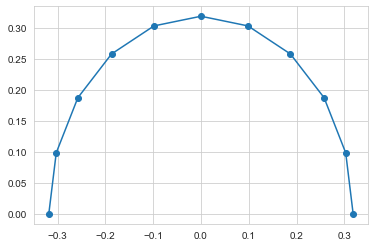

In [17]:
points = np.arange(0,1.1,0.1)

print(points)

x1 = 1/(math.pi)*np.cos(math.pi*points)

x2 = 1/(math.pi)*np.sin(math.pi*points)

sns.set_style('whitegrid')

plt.plot(x1,x2,linestyle='-',marker='o')
plt.show()

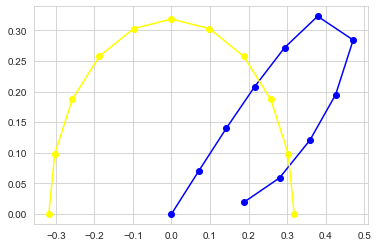

In [25]:
path = torch.tensor(np.array((x1,x2)).T)

k=10

signature = signatory.signature(path.unsqueeze(0), k)
signature_next = signatory.signature(path.unsqueeze(0), k+1)

reconstructed_path_derivatives = np.zeros(shape=(2,k))

reconstructed_path = np.zeros(shape=(2,k+1))

for p in np.arange(1,k+1):

    x_optimal = solve_optimization_problem(signature, signature_next,p,n=k,dimension=2)
    
    reconstructed_path_derivatives[:,p-1] = x_optimal 
    
    reconstructed_path[:,p] = reconstructed_path[:,p-1] + reconstructed_path_derivatives[:,p-1]*(1/k)
    
plt.plot(reconstructed_path[0,:],reconstructed_path[1,:],c='blue',marker='o')
plt.plot(x1,x2,linestyle='-',marker='o',c='yellow')
plt.show()
    